In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

from database.connection import sql_connection
from database.dataset import dataset_config
import lightgbm as lgb
from skopt.space import Real, Integer
from modules.interface import RunModel, RunOptimization
from plots import plots
import numpy as np
import pandas as pd

In [2]:
random_state=1
stdrings = sql_connection.set_standard_rings_data()
qrings=sql_connection.set_quarter_rings_data()
# params=[[{'cluster_eta':[0.6, 0.8]}, {'cluster_et':[20000,30000]}],
#         [{'cluster_eta':[1.2, 1.8]}, {'cluster_et':[100000, 250000]}]]

dataset=dataset_config.split_dataframe(stdrings, params=None)
stdrings_data = dataset_config.prepare_and_split_data(
    input_type='std_rings',
    stdrings_df=stdrings,
    train_size= 0.7,
    random_state=random_state
)

qrings_data= dataset_config.prepare_and_split_data(
    input_type='quarter_rings',
    stdrings_df=stdrings,
    qrings_df=qrings,
    train_size= 0.7,
    mode='delta',
    random_state=random_state
    )

In [3]:
space_lgbm = [
    Real(name='learning_rate', low = 0.01 , high = 0.9),
    Integer(name='num_leaves', low = 200, high = 700),
    Integer(name='max_depth', low = 200, high = 700),
    Real(name='feature_fraction', low = 0.5 , high = 1),
    Real(name='bagging_fraction', low = 0.7 , high = 1),
    Integer(name='bagging_freq', low = 1, high = 10),
    Real(name='lambda_l1',low = 0.0, high = 1),
    Real(name='lambda_l2',low = 0.5, high = 1)
]

fixed_params_lgbm = {
    "boosting_type": "gbdt",
    'objective': 'mae', 
    'metric': 'mae', 
    'num_iterations ': 500,
    'random_state': random_state, 
    'n_jobs': -1, 
    'verbose': -1
}

calibration_kwargs = {'callbacks':[lgb.early_stopping(stopping_rounds=5, verbose=False)]}
optimization_kwargs = {'n_initial_points': 1,
                        'n_calls': 2,
                        'initial_point_generator': 'lhs',
                        'random_state': random_state,

                       
                       }
bins_et = {'cluster_et':[5000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 150000, 200000, 250000,
                          900000, 3000000]}
bins_eta = {'cluster_eta':[0, 0.6, 0.8, 1.2, 1.37, 1.52, 1.8, 2.0, 2.2, 2.5]}

parameters_run_model = {
    "boosting_type": "gbdt",
    "objective": "mae",
    "metric": ["mae"],
    "num_leaves": 30,
    "max_depth": 7,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "num_boost_round": 1000,
    "early_stopping_rounds": 5,
    "lambda_l1": 0.0,
    "lambda_l2": 0.0,
    "force_row_wise": True,
    "verbosity": -1
}

parameters_run_model_1 = {
    "boosting_type": "gbdt",
    "objective": "mae",
    "metric": ["mae"],
    "num_leaves": 139,
    "max_depth": 300,
    "learning_rate": 0.095,
    "feature_fraction": 0.8,
    "bagging_fraction": 1,
    "bagging_freq": 10,
    "num_boost_round": 1000,
    "early_stopping_rounds": 5,
    "lambda_l1": 0.02,
    "lambda_l2": 0.72,
    "force_row_wise": True,
    "verbosity": -1
}

parameters_run_model_2 = {
    'boosting_type': 'gbdt',
    'objective': 'mae',
    'metric': ['mae'],
    'num_leaves': np.int64(652),
    'max_depth': np.int64(610),
    'learning_rate': 0.03818654645154271,
    'feature_fraction': 0.9039401105949553,
    'bagging_fraction': 0.7960565139652669,
    'bagging_freq': np.int64(6),
    'num_boost_round': np.int64(534),
    'early_stopping_rounds': 5,
    'lambda_l1': 0.4069025545005863,
    'lambda_l2': 0.6767363223435275,
    'force_row_wise': True,
    'verbosity': -1}


In [4]:
optimizer_lgbm = RunOptimization()
results=optimizer_lgbm.run(opt_class='gp_minimize',
    model_class="lgbm",
    datasets=stdrings_data,
    space=space_lgbm, 
    fixed_params=fixed_params_lgbm,
    metric='mae',
    calibration_kwargs=calibration_kwargs,
    optimization_kwargs= optimization_kwargs

)

y_test = []
y_pred = []
merged_dataframe=[]

for i in range(len(optimizer_lgbm.optimizer)):   
    optimizer_lgbm.optimizer[i].fit_best_model() 

    y_test.append(optimizer_lgbm.optimizer[i].y_test)
    y_pred.append(optimizer_lgbm.optimizer[i].y_pred)

for i in range(len(optimizer_lgbm.optimizer)):
    merged_dataframe.append(plots.merge_dataframes(
        stdrings.loc[optimizer_lgbm.optimizer[i].y_test.index],
        y_test[i],
        y_pred[i])
    )

merged_dataframe = pd.concat(merged_dataframe, ignore_index=True)

et_metric=plots.parameters_filter(merged_dataframe, bins_et)
eta_metric=plots.parameters_filter(merged_dataframe, bins_eta)
et_plot=plots.evaluate_metrics(et_metric, y_test_col='alpha', y_pred_col='y_pred')
eta_plot=plots.evaluate_metrics(eta_metric, y_test_col='alpha', y_pred_col='y_pred')

eta_plot_params={'y_data': eta_plot,}
et_plot_params={'y_data': et_plot,}

print(eta_plot_params)
print(et_plot_params)

Training the final model with the best parameters...
Final model has been trained and is stored in the '.best_model_' attribute.
{'y_data': [np.float64(0.02169296212644023), np.float64(0.03002314844594345), np.float64(0.031752173358797986), np.float64(0.033095488112599325), np.float64(0.06582358950000256), np.float64(0.05342899869292406), np.float64(0.0297806875965414), np.float64(0.027422613263697215), np.float64(0.029000018514026338), np.float64(0.06055494089126312)]}
{'y_data': [np.float64(0.14559695167617548), np.float64(0.08446139841990596), np.float64(0.0574310665281339), np.float64(0.04635234140984601), np.float64(0.039862182007724734), np.float64(0.03455585570080355), np.float64(0.029707068318084007), np.float64(0.02597546486071356), np.float64(0.023714719101700976), np.float64(0.02244619270494208), np.float64(0.02356480980157505), np.float64(0.02605583023268765)]}


In [5]:
merged_dataframe_lgbm_models=[]
# PRETRAINED_MODEL_PATH = r'D:\Doutorado\calibration\calibration_refactor\debug_code\standartRINGS.txt'
# loaded_booster = lgb.Booster(model_file=PRETRAINED_MODEL_PATH)

lgbm_model = RunModel()
results_lgbm_model=lgbm_model.run(
    model_class="lgbm",
    datasets=stdrings_data,
    params=parameters_run_model_2,
    calibration_kwargs= calibration_kwargs
)
for i in range(len(lgbm_model.models)):
    lgbm_model.models[i].predict()
    #lgbm_model.models[i].predict(loaded_booster)
    print(type(lgbm_model.models[i].X_test))
    print(type(lgbm_model.models[i].y_test))
    if lgbm_model.models[i].X_test.index.equals(stdrings.loc[lgbm_model.models[i].y_test.index].index):
        print("Índices são iguais")
    else:
        print("Índices são diferentes")


    merged_dataframe_lgbm_models.append(plots.merge_dataframes(
        stdrings.loc[lgbm_model.models[i].y_test.index],
        lgbm_model.models[i].y_test, 
        lgbm_model.models[i].y_pred)
    )
merged_dataframe_lgbm_models = pd.concat(merged_dataframe_lgbm_models, ignore_index=True)
print(merged_dataframe_lgbm_models.columns.to_list())

et_metric_models=plots.parameters_filter(merged_dataframe_lgbm_models, bins_et)
eta_metric_models=plots.parameters_filter(merged_dataframe_lgbm_models, bins_eta)
et_plot_models=plots.evaluate_metrics(et_metric_models, y_test_col='alpha', y_pred_col='y_pred')
eta_plot_models=plots.evaluate_metrics(eta_metric_models, y_test_col='alpha', y_pred_col='y_pred')
print(len(et_metric_models))
print(len(eta_metric_models))
et_plot_params_models={'y_data': et_plot_models,}
eta_plot_params_models={'y_data': eta_plot_models,}


print(eta_plot_params_models)
print(et_plot_params_models)

c:\Users\ricar\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
Índices são iguais
['cluster_eta', 'cluster_et', 'alpha', 'y_pred']
12
10
{'y_data': [np.float64(0.02026201919040138), np.float64(0.028946958611408502), np.float64(0.03043091093061001), np.float64(0.030662554111637208), np.float64(0.056856699110930276), np.float64(0.04735840169787031), np.float64(0.02693605591536774), np.float64(0.025369490181971655), np.float64(0.02740948669148835), np.float64(0.06167948056610406)]}
{'y_data': [np.float64(0.1347072434505281), np.float64(0.07848531880571774), np.float64(0.053843301709581626), np.float64(0.043446708487383634), np.float64(0.03719794123119036), np.float64(0.03272982106687994), np.float64(0.028113765040092886), np.float64(0.024424858583829256), np.float64(0.022042487810348566), np.float64(0.021091204860970825), np.float64(0.021329204465324048), np.float64(0.022500491615989104)]}


In [6]:
qrings_merged_dataframe_lgbm_models=[]
# PRETRAINED_MODEL_PATH = r'D:\Doutorado\calibration\calibration_refactor\debug_code\standartRINGS.txt'
# loaded_booster = lgb.Booster(model_file=PRETRAINED_MODEL_PATH)

qrings_lgbm_model = RunModel()
qrings_results_lgbm_model=qrings_lgbm_model.run(
    model_class="lgbm",
    datasets=qrings_data,
    params=parameters_run_model_2,
    calibration_kwargs= calibration_kwargs
)
for i in range(len(qrings_lgbm_model.models)):
    qrings_lgbm_model.models[i].predict()
    #lgbm_model.models[i].predict(loaded_booster)
    print(type(qrings_lgbm_model.models[i].X_test))
    print(type(qrings_lgbm_model.models[i].y_test))

    qrings_merged_dataframe_lgbm_models.append(plots.merge_dataframes(
        qrings.loc[qrings_lgbm_model.models[i].y_test.index],
        qrings_lgbm_model.models[i].y_test, 
        qrings_lgbm_model.models[i].y_pred)
    )
qrings_merged_dataframe_lgbm_models = pd.concat(qrings_merged_dataframe_lgbm_models, ignore_index=True)
print(qrings_merged_dataframe_lgbm_models.columns.to_list())

qrings_et_metric_models=plots.parameters_filter(qrings_merged_dataframe_lgbm_models, bins_et)
qrings_eta_metric_models=plots.parameters_filter(qrings_merged_dataframe_lgbm_models, bins_eta)
qrings_et_plot_models=plots.evaluate_metrics(qrings_et_metric_models, y_test_col='alpha', y_pred_col='y_pred')
qrings_eta_plot_models=plots.evaluate_metrics(qrings_eta_metric_models, y_test_col='alpha', y_pred_col='y_pred')
print(len(qrings_et_metric_models))
print(len(qrings_eta_metric_models))
qrings_et_plot_params_models={'y_data': qrings_et_plot_models,}
qrings_eta_plot_params_models={'y_data': qrings_eta_plot_models,}


print(qrings_eta_plot_params_models)
print(qrings_et_plot_params_models)

c:\Users\ricar\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
['cluster_eta', 'cluster_et', 'alpha', 'y_pred']
12
10
{'y_data': [np.float64(0.01915131624309052), np.float64(0.026725329531886444), np.float64(0.028846512969426863), np.float64(0.02975741153744671), np.float64(0.055897531528859234), np.float64(0.044849515270557916), np.float64(0.026068806905191977), np.float64(0.024433521561499028), np.float64(0.026625499217864834), np.float64(0.09228119806744162)]}
{'y_data': [np.float64(0.13021497102076252), np.float64(0.07623519171366455), np.float64(0.05194599866786542), np.float64(0.04210755639796515), np.float64(0.03602018116105321), np.float64(0.03150251162522255), np.float64(0.0265289035714793), np.float64(0.023091970426763142), np.float64(0.020804527445155152), np.float64(0.019710180807616995), np.float64(0.02036795461096208), np.float64(0.021793893980995405)]}


In [7]:
# def save_list_of_dfs_to_excel(dfs_list, output_file, prefix="Sheet"):
#     """
#     Salva uma lista de DataFrames em um único arquivo Excel.
#     Cada DataFrame vai para uma sheet diferente.

#     Parameters
#     ----------
#     dfs_list : list[pd.DataFrame]
#         Lista de DataFrames a serem salvos.
#     output_file : str
#         Caminho do arquivo .xlsx de saída.
#     prefix : str
#         Prefixo usado nos nomes das sheets (default: "Sheet").
#     """
#     with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
#         for i, df in enumerate(dfs_list, start=1):
#             sheet_name = f"{prefix}_{i}"
#             df.to_excel(writer, sheet_name=sheet_name, index=False)

# # Salvar as duas variáveis
# save_list_of_dfs_to_excel(et_metric_models, "et_metric_models.xlsx", prefix="et")
# save_list_of_dfs_to_excel(eta_metric_models, "eta_metric_models.xlsx", prefix="eta")


# file_path = "merged_dataframe_lgbm_models.xlsx"  # nome do arquivo de saída

# # Salvar DataFrame em Excel
# merged_dataframe_lgbm_models.to_excel(file_path, index=False)

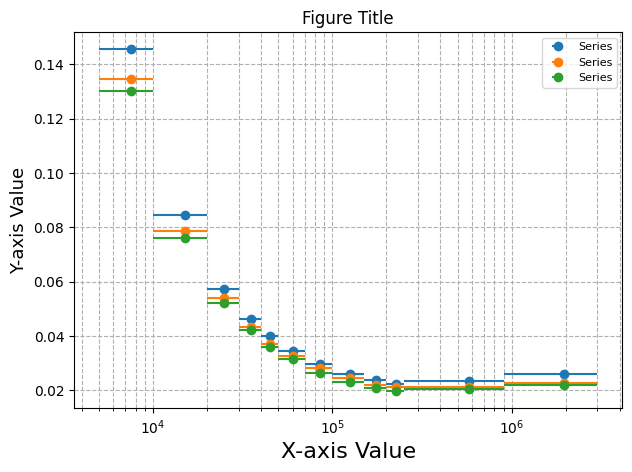

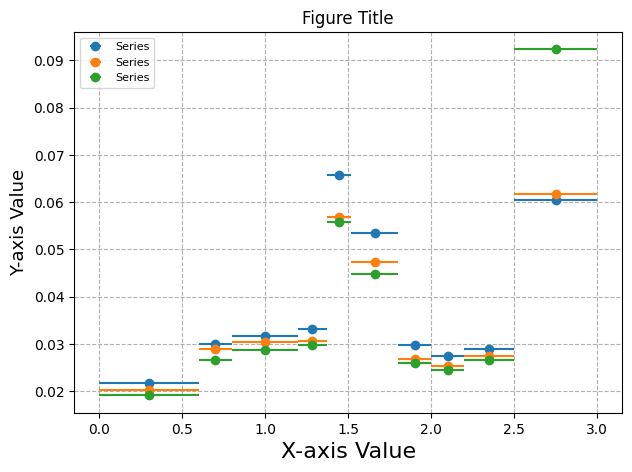

In [8]:
bins_eta = {'cluster_eta':[0, 0.6, 0.8, 1.2, 1.37, 1.52, 1.8, 2.0, 2.2, 2.5, 3]}
plots.plot_errorbars(plot_configs=[et_plot_params, et_plot_params_models, qrings_et_plot_params_models],bins=bins_et,xscale='log')
plots.plot_errorbars(plot_configs=[eta_plot_params, eta_plot_params_models, qrings_eta_plot_params_models],bins=bins_eta)